In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_A.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [6]:
data_std.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_A'] 
X = data_std.drop(['Coeff_A','Name'], axis=1)

### Using CV technique

RF
R2:  0.8392427536298988
RMSE:  0.40094544064012166
---------------------------------------
GB
R2:  0.7578004569662065
RMSE:  0.49213772770820313
---------------------------------------
LR
R2:  0.7544959398371425
RMSE:  0.4954836628617109
---------------------------------------
RR
R2:  0.7546018297499612
RMSE:  0.49537679623700465
---------------------------------------
LASSO
R2:  0.75475610395934
RMSE:  0.4952210577516468
---------------------------------------
gpr1
R2:  0.7618300417674011
RMSE:  0.4880265958250624
---------------------------------------
gpr2
R2:  0.8133016735573393
RMSE:  0.43208601741165
---------------------------------------
gpr3
R2:  0.42925529881747804
RMSE:  0.7554764729510257
---------------------------------------
gpr4
R2:  0.543486564973392
RMSE:  0.6756577795205262
---------------------------------------
gpr5
R2:  0.7924571233513786
RMSE:  0.4555687397623122
---------------------------------------
gpr6
R2:  0.842708967488014
RMSE:  0.3965993349868176
----

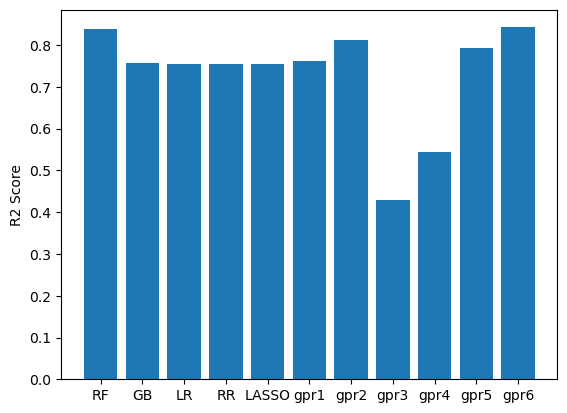

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  142.353080
4   mean_X2X   79.003498
2   mean_A2X   55.191431
9      E_coh   34.402479
6    std_A2X   18.021854
7    std_B2X   16.580759
11        OF   14.513522
5    std_A2B    5.578229
8    std_X2X    4.707386
10        TF    3.235088
0    density    0.786164
3   mean_B2X    0.122504


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8378237264353112
RMSE:  0.4027111540107733
---------------------------------------
GB
R2:  0.748082336458145
RMSE:  0.5019140001452987
---------------------------------------
LR
R2:  0.7544959398371422
RMSE:  0.495483662861711
---------------------------------------
RR
R2:  0.7546018297499612
RMSE:  0.49537679623700465
---------------------------------------
LASSO
R2:  0.754736041816652
RMSE:  0.4952413130821661
---------------------------------------
gpr1
R2:  0.7618300417673955
RMSE:  0.4880265958250682
---------------------------------------
gpr2
R2:  0.8133016735573402
RMSE:  0.4320860174116489
---------------------------------------
gpr3
R2:  0.4366238437406629
RMSE:  0.75058387689807
---------------------------------------
gpr4
R2:  0.5434865649733933
RMSE:  0.6756577795205253
---------------------------------------
gpr5
R2:  0.792457123350981
RMSE:  0.45556873976274875
---------------------------------------
gpr6
R2:  0.8427089674880144
RMSE:  0.39659933498681715
-----

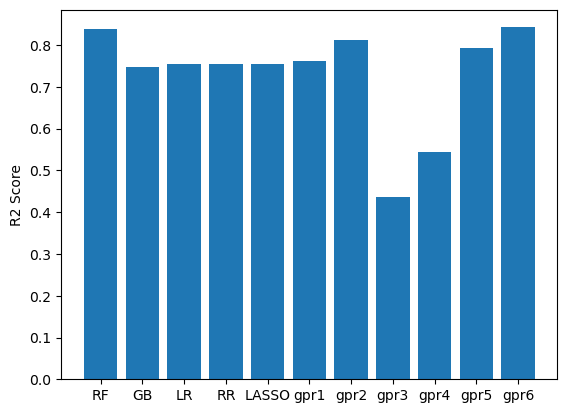

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8378237264353112
RMSE:  0.4027111540107733
---------------------------------------
GB
R2:  0.7561864151018479
RMSE:  0.49377483218381235
---------------------------------------
LR
R2:  0.7544959398371422
RMSE:  0.495483662861711
---------------------------------------
RR
R2:  0.7546018297499612
RMSE:  0.49537679623700465
---------------------------------------
LASSO
R2:  0.754736041816652
RMSE:  0.4952413130821661
---------------------------------------
gpr1
R2:  0.7618300417673955
RMSE:  0.4880265958250682
---------------------------------------
gpr2
R2:  0.8133016735573402
RMSE:  0.4320860174116489
---------------------------------------
gpr3
R2:  0.45126218771740023
RMSE:  0.7407683931449828
---------------------------------------
gpr4
R2:  0.5434865649733933
RMSE:  0.6756577795205253
---------------------------------------
gpr5
R2:  0.792457123350981
RMSE:  0.45556873976274875
---------------------------------------
gpr6
R2:  0.8427089674880144
RMSE:  0.39659933498681715


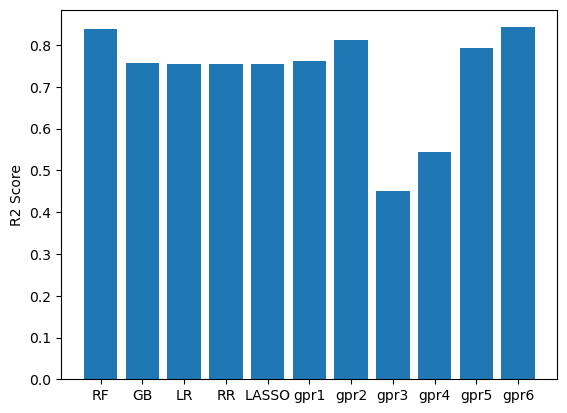

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8378237264353112
RMSE:  0.4027111540107733
---------------------------------------
GB
R2:  0.7503023453509453
RMSE:  0.49969756318102526
---------------------------------------
LR
R2:  0.7544959398371422
RMSE:  0.495483662861711
---------------------------------------
RR
R2:  0.7546018297499612
RMSE:  0.49537679623700465
---------------------------------------
LASSO
R2:  0.754736041816652
RMSE:  0.4952413130821661
---------------------------------------
gpr1
R2:  0.7618300417673955
RMSE:  0.4880265958250682
---------------------------------------
gpr2
R2:  0.8133016735573402
RMSE:  0.4320860174116489
---------------------------------------
gpr3
R2:  0.4691766132206162
RMSE:  0.7285762738240821
---------------------------------------
gpr4
R2:  0.5434865649733933
RMSE:  0.6756577795205253
---------------------------------------
gpr5
R2:  0.792457123350981
RMSE:  0.45556873976274875
---------------------------------------
gpr6
R2:  0.8427089674880144
RMSE:  0.39659933498681715
-

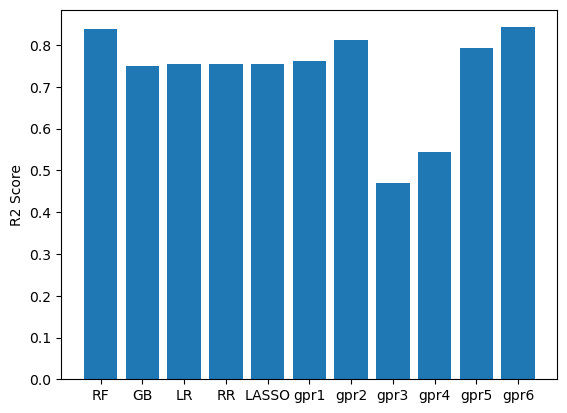

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8619135641273268
RMSE:  0.371599832982569
---------------------------------------
GB
R2:  0.7099270313676935
RMSE:  0.5385842261265237
---------------------------------------
LR
R2:  0.6954685551505982
RMSE:  0.5518436779101503
---------------------------------------
RR
R2:  0.6955865951687041
RMSE:  0.5517367169504817
---------------------------------------
LASSO
R2:  0.7085217193469427
RMSE:  0.5398872851374231
---------------------------------------
gpr1
R2:  0.7105509938023312
RMSE:  0.5380046525799463
---------------------------------------
gpr2
R2:  0.773443967064692
RMSE:  0.47597902573044965
---------------------------------------
gpr3
R2:  0.45042464890861333
RMSE:  0.741333495190516
---------------------------------------
gpr4
R2:  0.4754648189888797
RMSE:  0.72424801070567
---------------------------------------
gpr5
R2:  0.8233076211420055
RMSE:  0.4203479259589542
---------------------------------------
gpr6
R2:  0.8348193992963306
RMSE:  0.40642416353321
-------

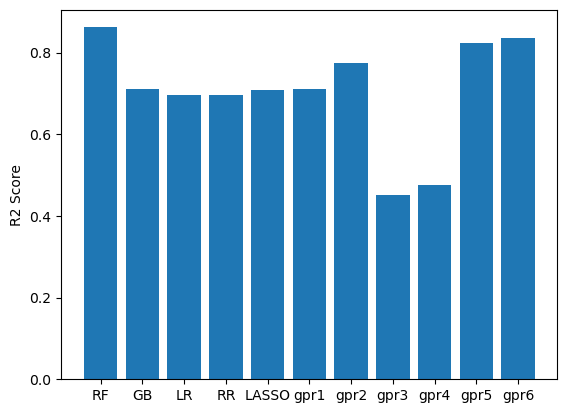

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_A.csv', encoding='cp1252')

In [24]:
data_mm.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_A'] 
X = data_mm.drop(['Coeff_A','Name'], axis=1)

### Using CV technique

RF
R2:  0.8497913240208543
RMSE:  0.10463184216830453
---------------------------------------
GB
R2:  0.7698029149858445
RMSE:  0.12952877926692533
---------------------------------------
LR
R2:  0.7544959398371424
RMSE:  0.13376598815062407
---------------------------------------
RR
R2:  0.7565029491500896
RMSE:  0.13321809389882233
---------------------------------------
LASSO
R2:  0.6659243280157197
RMSE:  0.15604102267700892
---------------------------------------
gpr1
R2:  0.7612262238744454
RMSE:  0.13191970652715446
---------------------------------------
gpr2
R2:  0.7969577940181628
RMSE:  0.12164927479706182
---------------------------------------
gpr3
R2:  -0.24073141901409634
RMSE:  0.30071511141657187
---------------------------------------
gpr4
R2:  -0.24073148121391807
RMSE:  0.30071511895423303
---------------------------------------
gpr5
R2:  0.7687218845921668
RMSE:  0.1298325636078653
---------------------------------------
gpr6
R2:  0.8359651661922813
RMSE:  0.109341

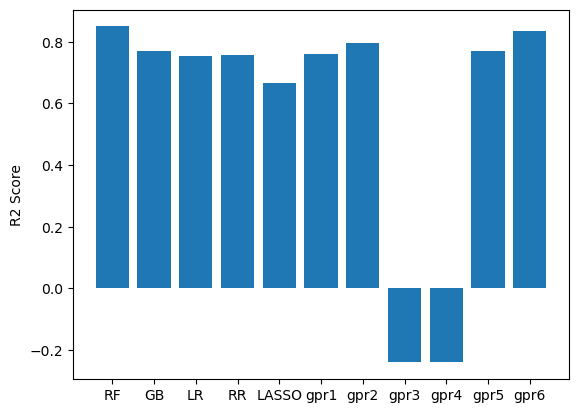

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  142.353080
4   mean_X2X   79.003498
2   mean_A2X   55.191431
9      E_coh   34.402479
6    std_A2X   18.021854
7    std_B2X   16.580759
11        OF   14.513522
5    std_A2B    5.578229
8    std_X2X    4.707386
10        TF    3.235088
0    density    0.786164
3   mean_B2X    0.122504


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8482797787187242
RMSE:  0.10515697787937243
---------------------------------------
GB
R2:  0.7393332515815614
RMSE:  0.13783489505489827
---------------------------------------
LR
R2:  0.7544959398371427
RMSE:  0.13376598815062402
---------------------------------------
RR
R2:  0.7565029491500898
RMSE:  0.13321809389882233
---------------------------------------
LASSO
R2:  0.665924589847622
RMSE:  0.15604096152839914
---------------------------------------
gpr1
R2:  0.7612262238748457
RMSE:  0.13191970652704385
---------------------------------------
gpr2
R2:  0.796957794018166
RMSE:  0.12164927479706084
---------------------------------------
gpr3
R2:  -0.24073118761168244
RMSE:  0.3007150833741588
---------------------------------------
gpr4
R2:  -0.24073148121390853
RMSE:  0.30071511895423186
---------------------------------------
gpr5
R2:  0.768721884592144
RMSE:  0.1298325636078717
---------------------------------------
gpr6
R2:  0.8359651308980607
RMSE:  0.1093413548

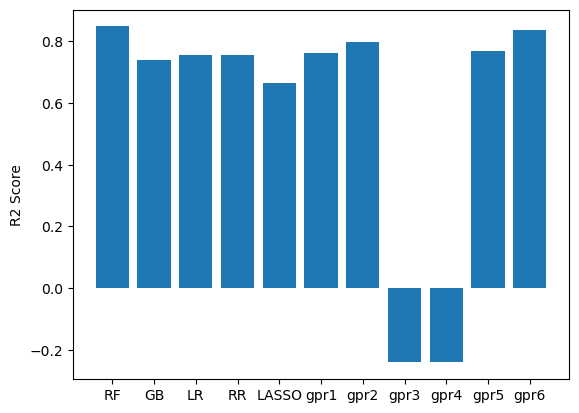

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8482797787187242
RMSE:  0.10515697787937243
---------------------------------------
GB
R2:  0.7486433694843774
RMSE:  0.13535102083093337
---------------------------------------
LR
R2:  0.7544959398371427
RMSE:  0.13376598815062402
---------------------------------------
RR
R2:  0.7565029491500898
RMSE:  0.13321809389882233
---------------------------------------
LASSO
R2:  0.665924589847622
RMSE:  0.15604096152839914
---------------------------------------
gpr1
R2:  0.7612262238748457
RMSE:  0.13191970652704385
---------------------------------------
gpr2
R2:  0.796957794018166
RMSE:  0.12164927479706084
---------------------------------------
gpr3
R2:  -0.24073149925969228
RMSE:  0.3007151211411031
---------------------------------------
gpr4
R2:  -0.24073148121390853
RMSE:  0.30071511895423186
---------------------------------------
gpr5
R2:  0.768721884592144
RMSE:  0.1298325636078717
---------------------------------------
gpr6
R2:  0.8359651308980607
RMSE:  0.1093413548

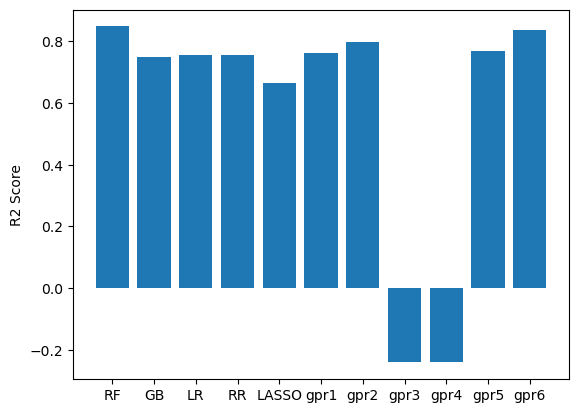

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8482797787187242
RMSE:  0.10515697787937243
---------------------------------------
GB
R2:  0.7707242944559047
RMSE:  0.1292692954872695
---------------------------------------
LR
R2:  0.7544959398371427
RMSE:  0.13376598815062402
---------------------------------------
RR
R2:  0.7565029491500898
RMSE:  0.13321809389882233
---------------------------------------
LASSO
R2:  0.665924589847622
RMSE:  0.15604096152839914
---------------------------------------
gpr1
R2:  0.7612262238748457
RMSE:  0.13191970652704385
---------------------------------------
gpr2
R2:  0.796957794018166
RMSE:  0.12164927479706084
---------------------------------------
gpr3
R2:  -0.24073148119525434
RMSE:  0.3007151189519713
---------------------------------------
gpr4
R2:  -0.24073148121390853
RMSE:  0.30071511895423186
---------------------------------------
gpr5
R2:  0.768721884592144
RMSE:  0.1298325636078717
---------------------------------------
gpr6
R2:  0.8359651308980607
RMSE:  0.10934135482

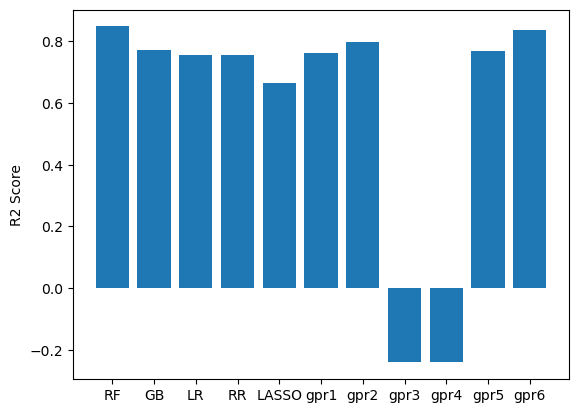

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8773223746088061
RMSE:  0.09455816662217692
---------------------------------------
GB
R2:  0.7470540944448197
RMSE:  0.13577824458361387
---------------------------------------
LR
R2:  0.6954685551505981
RMSE:  0.14898153140707793
---------------------------------------
RR
R2:  0.6980424371600937
RMSE:  0.1483506038305225
---------------------------------------
LASSO
R2:  0.665924589847622
RMSE:  0.15604096152839914
---------------------------------------
gpr1
R2:  0.7019403479455499
RMSE:  0.14738997924965733
---------------------------------------
gpr2
R2:  0.7559254175337166
RMSE:  0.13337598512224244
---------------------------------------
gpr3
R2:  -0.9423600073531546
RMSE:  0.3762540872647385
---------------------------------------
gpr4
R2:  -0.9423599758090779
RMSE:  0.37625408420954076
---------------------------------------
gpr5
R2:  0.7993649194088517
RMSE:  0.12092603077606753
---------------------------------------
gpr6
R2:  0.8207950656537655
RMSE:  0.1142855557

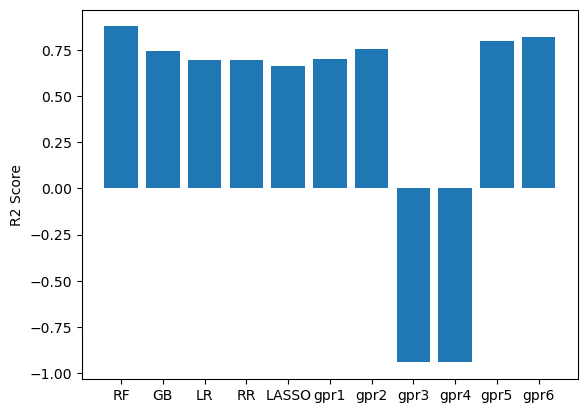

In [40]:
run_models()